## COMP5328 - Advanced Machine Learning
## Assignment 2: Implement a transition matrix estimator and two classification algorithms that are robust to label noise
----------------------------------------------------------------------------------------

## 1 Data exploration

### 1.0 List files in 'data' folder

In [2]:
# The structure of data folder.
!ls -l ../data

total 86344
-rwxrwxrwx 1 root root 55440974 Oct 24 07:37 CIFAR.npz
-rwxrwxrwx 1 root root 16485974 Oct 24 07:37 FashionMNIST0.3.npz
-rwxrwxrwx 1 root root 16485974 Oct 24 07:37 FashionMNIST0.6.npz


### 1.1 Load dataset

In [34]:
import os
import numpy as np
from PIL import Image

def load_data(file="../data/CIFAR.npz", reduce=1, normalize=True):
    """
    Load a .npz dataset and optionally resize and normalize images.

    Args:
        file (str): Path to the dataset file (e.g., '../data/CIFAR.npz').
        reduce (int): Factor by which to reduce image height and width.
                      For example, reduce=4 makes images 1/4 their original size.
        normalize (bool): If True, scale image pixel values to [0, 1].

    Returns:
        Xtr (np.ndarray): Training images, shape (n_train, h, w, c)
        Str (np.ndarray): Training labels
        Xts (np.ndarray): Test images, shape (n_test, h, w, c)
        Yts (np.ndarray): Test labels
    """

    # Check if file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"Dataset not found: {file}")

    # Load dataset from .npz file using keys: 'Xtr', 'Str', 'Xts', 'Yts'
    dataset = np.load(file)
    Xtr, Str, Xts, Yts = dataset["Xtr"], dataset["Str"], dataset["Xts"], dataset["Yts"]

    # Process training images - handle different shapes:

    # 1) Flattened grayscale images: (n_samples, h*w) -> reshape to (n, h, w, 1)
    if len(Xtr.shape) == 2:
        n, d = Xtr.shape
        side = int(np.sqrt(d))  # assume square images
        Xtr = Xtr.reshape((n, side, side, 1))
    # 2) 3D grayscale images: (n_samples, h, w) -> add channel dimension
    elif len(Xtr.shape) == 3:
        Xtr = np.expand_dims(Xtr, -1)

    # Resize images if reduce factor > 1
    if reduce > 1:
        n, h, w, c = Xtr.shape
        new_h, new_w = h // reduce, w // reduce
        resized = np.zeros((n, new_h, new_w, c), dtype=Xtr.dtype)
        for i in range(n):
            # Convert numpy array to PIL image for resizing
            img = Image.fromarray(Xtr[i].squeeze())
            img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)
            # Put back into numpy array
            if c == 1:
                resized[i, :, :, 0] = np.array(img)
            else:
                resized[i] = np.array(img)
        Xtr = resized

    # Normalize pixel values to [0,1] if requested
    if normalize:
        Xtr = Xtr.astype(np.float32) / 255.0

    # Process test images - handle different shapes:
    # 1) Flattened grayscale images: (n_samples, h*w) -> reshape to (n, h, w, 1)
    if len(Xts.shape) == 2:
        n, d = Xts.shape
        side = int(np.sqrt(d))
        Xts = Xts.reshape((n, side, side, 1))
    # 2) 3D grayscale images: (n_samples, h, w) -> add channel dimension
    elif len(Xts.shape) == 3:
        Xts = np.expand_dims(Xts, -1)

    # Resize images if reduce factor > 1
    if reduce > 1:
        n, h, w, c = Xts.shape
        new_h, new_w = h // reduce, w // reduce
        resized = np.zeros((n, new_h, new_w, c), dtype=Xts.dtype)
        for i in range(n):
            img = Image.fromarray(Xts[i].squeeze())
            img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)
            if c == 1:
                resized[i, :, :, 0] = np.array(img)
            else:
                resized[i] = np.array(img)
        Xts = resized

    # Normalize pixel values to [0,1] if requested
    if normalize:
        Xts = Xts.astype(np.float32) / 255.0

    # Return processed datasets
    return Xtr, Str, Xts, Yts


# Load CIFAR dataset.
Xtr_cifar, Str_cifar, Xts_cifar, Yts_cifar = load_data(
    file="../data/CIFAR.npz", reduce=1, normalize=True
)

# Load FashionMNIST0.3 dataset.
Xtr_fm3, Str_fm3, Xts_fm3, Yts_fm3 = load_data(
    file="../data/FashionMNIST0.3.npz", reduce=1, normalize=True
)

# Load FashionMNIST0.6 dataset.
Xtr_fm6, Str_fm6, Xts_fm6, Yts_fm6 = load_data(
    file="../data/FashionMNIST0.6.npz", reduce=1, normalize=True
)

In [33]:
import pandas as pd
from tabulate import tabulate

# Dataset dictionary
datasets = {
    "CIFAR": (Xtr_cifar, Str_cifar, Xts_cifar, Yts_cifar),
    "FashionMNIST0.3": (Xtr_fm3, Str_fm3, Xts_fm3, Yts_fm3),
    "FashionMNIST0.6": (Xtr_fm6, Str_fm6, Xts_fm6, Yts_fm6),
}

summary = []

for name, (Xtr, Str, Xts, Yts) in datasets.items():
    n_train = Xtr.shape[0]
    n_test = Xts.shape[0]
    n_class = len(set(Str))
    # Flatten image size nicely
    img_size = "x".join(map(str, Xtr.shape[1:]))
    summary.append([name, n_train, n_test, n_class, img_size])

# Create DataFrame
df_summary = pd.DataFrame(
    summary, columns=["Dataset", "# Train", "# Test", "# Classes", "Image Size"]
)

# Pretty-print table
print(tabulate(df_summary, headers="keys", tablefmt="fancy_grid", showindex=False))

╒═════════════════╤═══════════╤══════════╤═════════════╤══════════════╕
│ Dataset         │   # Train │   # Test │   # Classes │ Image Size   │
╞═════════════════╪═══════════╪══════════╪═════════════╪══════════════╡
│ CIFAR           │     15000 │     3000 │           3 │ 32x32x3      │
├─────────────────┼───────────┼──────────┼─────────────┼──────────────┤
│ FashionMNIST0.3 │     18000 │     3000 │           3 │ 28x28x1      │
├─────────────────┼───────────┼──────────┼─────────────┼──────────────┤
│ FashionMNIST0.6 │     18000 │     3000 │           3 │ 28x28x1      │
╘═════════════════╧═══════════╧══════════╧═════════════╧══════════════╛


### 1.2 View sample images

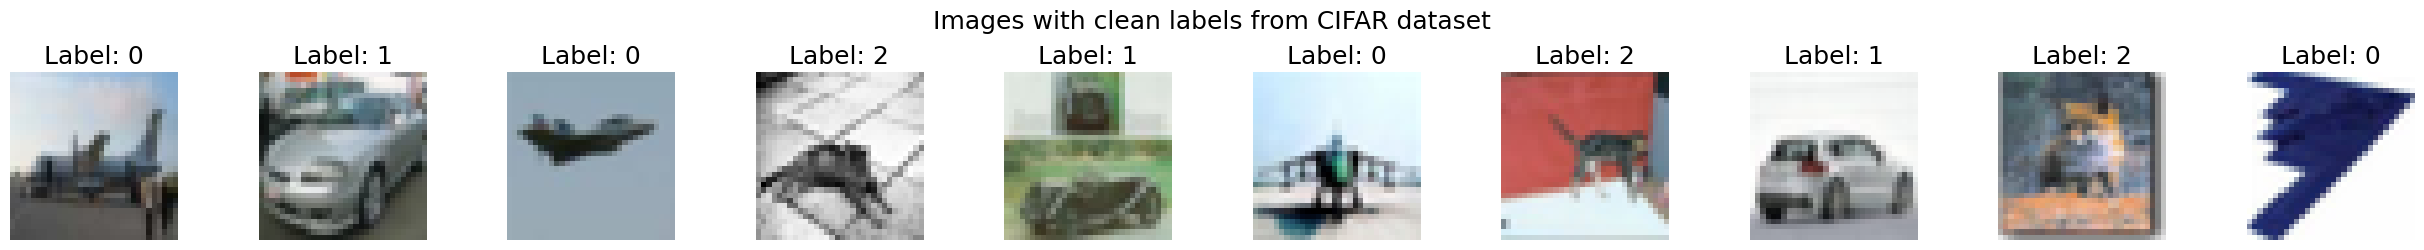

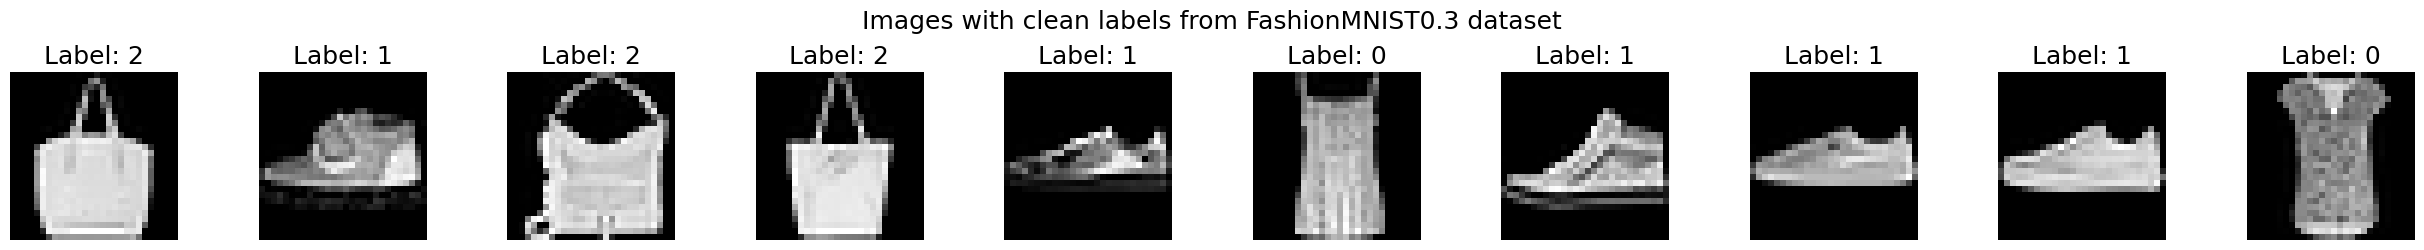

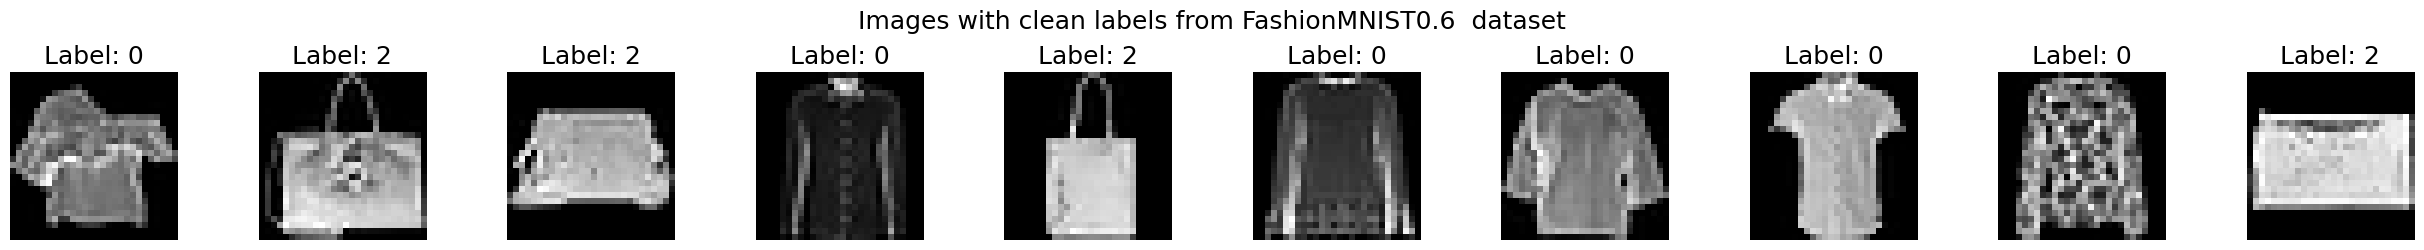

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_grid(images, labels, title="Sample images", n=10):
    """
    Display 'n' random sample images with automatic grayscale detection.
    """

    n = min(n, len(images))
    idx = np.random.choice(len(images), n, replace=False)
    fig, axes = plt.subplots(1, n, figsize=(n * 2.5, 2.5))
    fig.suptitle(title, fontsize=18)

    for i, ax in enumerate(axes):
        img = images[idx[i]]
        label = labels[idx[i]]

        # Remove singleton dimensions (grayscale images)
        img = np.squeeze(img)

        ax.imshow(img, cmap="gray" if img.ndim == 2 else None)
        ax.set_title(f"Label: {label}", fontsize=18)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


np.random.seed(42)  # for replicability

show_image_grid(
    images=Xts_cifar,
    labels=Yts_cifar,
    title="Images with clean labels from CIFAR dataset",
)
show_image_grid(
    images=Xts_fm3,
    labels=Yts_fm3,
    title="Images with clean labels from FashionMNIST0.3 dataset",
)
show_image_grid(
    images=Xts_fm6,
    labels=Yts_fm6,
    title="Images with clean labels from FashionMNIST0.6  dataset",
)

### 1.3 Convert NumPy images to PyTorch tensors

In [37]:
import torch

def to_torch_tensors(Xtr, Str, Xts, Yts, device=None):
    """
    Convert NumPy datasets to PyTorch tensors suitable for CNNs.

    Args:
        Xtr (np.ndarray): Training images, shape (n, h, w, c)
        Str (np.ndarray): Training labels
        Xts (np.ndarray): Test images, shape (n, h, w, c)
        Yts (np.ndarray): Test labels
        device (torch.device or str, optional): Device to move tensors to (CPU or GPU).
            If None, defaults to 'cuda' if available, else 'cpu'.

    Returns:
        Xtr_tensor, Str_tensor, Xts_tensor, Yts_tensor (torch.Tensor): Tensors on specified device
            X shape: (n, c, h, w)
            Labels shape: (n,)
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert images to float32 tensors
    Xtr_tensor = torch.tensor(Xtr, dtype=torch.float32)
    Xts_tensor = torch.tensor(Xts, dtype=torch.float32)

    # Convert labels to long tensors
    Str_tensor = torch.tensor(Str, dtype=torch.long)
    Yts_tensor = torch.tensor(Yts, dtype=torch.long)

    # Convert to channels-first format for CNNs: (n, h, w, c) -> (n, c, h, w)
    Xtr_tensor = Xtr_tensor.permute(0, 3, 1, 2)
    Xts_tensor = Xts_tensor.permute(0, 3, 1, 2)

    # Move tensors to the specified device (CPU or GPU)
    Xtr_tensor = Xtr_tensor.to(device, non_blocking=True)
    Str_tensor = Str_tensor.to(device, non_blocking=True)
    Xts_tensor = Xts_tensor.to(device, non_blocking=True)
    Yts_tensor = Yts_tensor.to(device, non_blocking=True)

    return Xtr_tensor, Str_tensor, Xts_tensor, Yts_tensor


# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xtr_cifar_t, Str_cifar_t, Xts_cifar_t, Yts_cifar_t = to_torch_tensors(
    Xtr_cifar, Str_cifar, Xts_cifar, Yts_cifar, device
)
print(
    f"Xtr_cifar_t.shape={Xtr_cifar_t.shape}, Str_cifar_t.shape={Str_cifar_t.shape}, "
    f"Xts_cifar_t.shape={Xts_cifar_t.shape}, Yts_cifar_t.shape={Yts_cifar_t.shape}"
)

Xtr_fm3_t, Str_fm3_t, Xts_fm3_t, Yts_fm3_t = to_torch_tensors(
    Xtr_fm3, Str_fm3, Xts_fm3, Yts_fm3, device
)
print(
    f"Xtr_fm3_t.shape={Xtr_fm3_t.shape}, Str_fm3_t.shape={Str_fm3_t.shape}, "
    f"Xts_fm3_t.shape={Xts_fm3_t.shape}, Yts_fm3_t.shape={Yts_fm3_t.shape}"
)

Xtr_fm6_t, Str_fm6_t, Xts_fm6_t, Yts_fm6_t = to_torch_tensors(
    Xtr_fm6, Str_fm6, Xts_fm6, Yts_fm6, device
)
print(
    f"Xtr_fm6_t.shape={Xtr_fm6_t.shape}, Str_fm6_t.shape={Str_fm6_t.shape}, "
    f"Xts_fm6_t.shape={Xts_fm6_t.shape}, Yts_fm6_t.shape={Yts_fm6_t.shape}"
)

Xtr_cifar_t.shape=torch.Size([15000, 3, 32, 32]), Str_cifar_t.shape=torch.Size([15000]), Xts_cifar_t.shape=torch.Size([3000, 3, 32, 32]), Yts_cifar_t.shape=torch.Size([3000])
Xtr_fm3_t.shape=torch.Size([18000, 1, 28, 28]), Str_fm3_t.shape=torch.Size([18000]), Xts_fm3_t.shape=torch.Size([3000, 1, 28, 28]), Yts_fm3_t.shape=torch.Size([3000])
Xtr_fm6_t.shape=torch.Size([18000, 1, 28, 28]), Str_fm6_t.shape=torch.Size([18000]), Xts_fm6_t.shape=torch.Size([3000, 1, 28, 28]), Yts_fm6_t.shape=torch.Size([3000])


## 2 Implementation

### 2.0 Define Small ResNet-style neural network with dropout (for CIFAR - more complex)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout2d(dropout_prob)  # Dropout after first conv
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(dropout_prob)  # Dropout after second conv
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.bn2(self.conv2(out))
        out = self.dropout2(out)
        out += self.shortcut(x)
        return F.relu(out)


class SmallResNet(nn.Module):
    def __init__(self, num_classes=3, dropout_prob=0.5):
        super().__init__()
        self.layer1 = BasicBlock(3, 32, dropout_prob=0.2)
        self.layer2 = BasicBlock(32, 64, stride=2, dropout_prob=0.3)
        self.layer3 = BasicBlock(64, 128, stride=2, dropout_prob=0.4)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout_fc = nn.Dropout(dropout_prob)  # Dropout before fully connected
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout_fc(x)
        x = self.fc(x)
        return x

### 2.1 Define a SmallCNN neural network with droput for FashionMNIST

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),  # small dropout in first block
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),  # moderate dropout after pooling
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),  # stronger dropout in deeper block
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # strong dropout in fully connected
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### 2.2 Define Transition Matrices

In [9]:
import numpy as np
import torch

# FashionMNIST0.3 transition matrix
T_fm3 = np.array([[0.7, 0.3, 0.0], [0.0, 0.7, 0.3], [0.3, 0.0, 0.7]])

# FashionMNIST0.6 transition matrix
T_fm6 = np.array([[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]])

print("FashionMNIST0.3 row sums:", T_fm3.sum(axis=1))
print("FashionMNIST0.6 row sums:", T_fm6.sum(axis=1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T_cifar_est = torch.load("T_cifar_est.pt").to(device)

# Convert to tensor
T_fm3_t = torch.tensor(T_fm3, dtype=torch.float32).to(device)
T_fm6_t = torch.tensor(T_fm6, dtype=torch.float32).to(device)

print(f"T_fm3_t.shape={T_fm3_t.shape}, T_fm6_t.shape={T_fm6_t.shape}")

FashionMNIST0.3 row sums: [1. 1. 1.]
FashionMNIST0.6 row sums: [1. 1. 1.]
T_fm3_t.shape=torch.Size([3, 3]), T_fm6_t.shape=torch.Size([3, 3])


### 2.3 Create Dataloaders (Helper function)

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_dataloaders_stratified(
    X_train,
    y_train,
    X_test,
    y_test,
    val_split=0.2,
    batch_size=64,
    seed=42,
    verbose=False,
):
    """
    Creates stratified train/validation/test DataLoaders,
    preserving class proportions.
    """
    torch.manual_seed(seed)
    classes = torch.unique(y_train)
    train_idx_list, val_idx_list = [], []

    # Split indices per y_train class
    for c in classes:
        class_idx = (y_train == c).nonzero(as_tuple=True)[0]  # indices of this class
        perm = torch.randperm(len(class_idx))  # shuffle
        split = int(len(class_idx) * (1 - val_split))  # train/val split point
        train_idx_list.append(class_idx[perm[:split]])
        val_idx_list.append(class_idx[perm[split:]])

    # Concatenate all y_train class indices
    train_idx = torch.cat(train_idx_list)
    val_idx = torch.cat(val_idx_list)

    # Create TensorDataset objects that pair features (X) and labels (Y)
    train_ds = TensorDataset(X_train[train_idx], y_train[train_idx])
    val_ds = TensorDataset(X_train[val_idx], y_train[val_idx])
    test_ds = TensorDataset(X_test, y_test)

    pin_memory = torch.cuda.is_available()

    # Create DataLoaders, which handle batching and iteration during training
    train_loader = DataLoader(
        train_ds, num_workers=2, pin_memory=pin_memory, batch_size=batch_size, shuffle=True
    )  # shuffle for training
    val_loader = DataLoader(
        val_ds, num_workers=2, pin_memory=pin_memory, batch_size=batch_size, shuffle=False
    )  # no need to shuffle validation data
    test_loader = DataLoader(
        test_ds, num_workers=2, pin_memory=pin_memory, batch_size=batch_size, shuffle=False
    )  # no need to shuffle test data

    # Print dataset sizes
    if verbose == True:
        print(f"\nStratified dataset split summary:")
        print(f"   • Training:    {len(train_ds)} samples")
        print(f"   • Validation:  {len(val_ds)} samples")
        print(f"   • Test:        {len(test_ds)} samples")

    # Print class distributions
    if verbose == True:
        print("Class distribution:")
    for split_name, y_split in zip(
        ["Training", "Validation", "Test"],
        [y_train[train_idx], y_train[val_idx], y_test],
    ):
        counts = torch.bincount(y_split, minlength=len(classes))
        dist = {int(c): int(counts[i]) for i, c in enumerate(classes)}
        if verbose == True:
            print(f"   • {split_name}: {dist}")

    return train_loader, val_loader, test_loader

### 2.4 Training + Validation (Helper function)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader


def train_model(
    model,
    train_loader,
    val_loader,
    loss_fn,
    T=None,
    num_epochs=20,
    warmup_epochs=3,
    eta=1e-3,
    eta_min=1e-5,
    patience=3,
    verbose=True,
):
    """
    Train a PyTorch model with early stopping, linear learning rate warmup,
    and cosine annealing scheduling.

    This function performs supervised training with optional label correction
    using a transition matrix `T`. It includes:
      • Linear learning rate warmup for the first few epochs.
      • Cosine annealing learning rate scheduling for stable convergence.
      • Early stopping when validation accuracy stops improving.
      • Automatic restoration of the best-performing model weights.
      • Returns both the best model and full training history.

    Args:
        model (nn.Module):
            The PyTorch model to be trained.

        train_loader (DataLoader):
            DataLoader providing the training dataset.

        val_loader (DataLoader):
            DataLoader providing the validation dataset.

        loss_fn (callable):
            Loss function used for training. Must accept either:
            - (logits, labels) if `T` is None, or
            - (logits, labels, T) if using a noise transition matrix.

        T (torch.Tensor, optional):
            Estimated label transition matrix (P(noisy | true)) used
            for loss correction. If None, the loss function is applied normally.

        num_epochs (int, default=20):
            Maximum number of epochs for training.

        warmup_epochs (int, default=3):
            Number of initial epochs for linear learning rate warmup.

        eta (float, default=1e-3):
            Initial (maximum) learning rate.

        eta_min (float, default=1e-5):
            Minimum learning rate used by the cosine annealing scheduler.

        patience (int, default=3):
            Early stopping patience — training stops if validation accuracy
            does not improve for this many consecutive epochs.

        verbose (bool, optional):
            If True, prints progress messages.

    Returns:
        nn.Module:
            The trained model, with parameters restored to those that achieved
            the best validation accuracy during training.
        history (dict): 
            Dictionary containing training history.
    """

    optimizer = optim.Adam(
        model.parameters(), lr=eta, weight_decay=1e-4
    )  # weight_decay, L2 regularization

    # Linear warm-up scheduler
    warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, start_factor=1e-3, end_factor=1.0, total_iters=warmup_epochs
    )

    # Cosine annealing scheduler for the rest of training
    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=(num_epochs - warmup_epochs), eta_min=eta_min
    )

    # ombine both schedulers
    scheduler = torch.optim.lr_scheduler.SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[warmup_epochs],
    )

    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_wts = model.state_dict()

    # For visualization
    history = {
        'epoch': [],
        'loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training step
        for X, y in train_loader:
            optimizer.zero_grad()  # clean gradient buffer
            logits = model(X)  # raw outputs (no softmax)
            if T == None:
                loss = loss_fn(logits, y)  # applies the loss_fn
            else:
                loss = loss_fn(
                    logits, y, T
                )  # applies the loss_fn with T as added parameter
            loss.backward()  # compute gradients, backpropagation
            optimizer.step()  # update weights
            running_loss += loss.item() * X.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Compute validation accuracy
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                outputs = model(X)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
        val_acc = 100 * val_correct / val_total

        scheduler.step()

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            # Save the best model weights
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1

        if verbose and epochs_no_improve >= patience:
            print(
                f"Early stopping triggered at epoch {epoch+1} — "
                f"Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.2f}% | eta: {optimizer.param_groups[0]['lr']:.6f}"
            )
            break

        if verbose and (epoch + 1) % max(1, (num_epochs // 5)) == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] — Loss: {epoch_loss:.4f} | "
                f"Val Acc: {val_acc:.2f}% | eta: {optimizer.param_groups[0]['lr']:.6f}"
            )

        history['epoch'].append(epoch)
        history['loss'].append(epoch_loss)
        history['val_acc'].append(val_acc)

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

### 2.5 Top-1 Accuracy (Helper functions)

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader


def compute_top1_accuracy(model, test_loader):
    """
    Compute the classification accuracy of a model on a given dataset.

    Args:
        model (torch.nn.Module): The trained PyTorch model to evaluate.
        test_loader (DataLoader): DataLoader providing the dataset to evaluate.
            Labels are assumed to be integer class indices.

    Returns:
        float: Accuracy as a percentage of correctly classified samples.
    """
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    return 100 * test_correct / test_total


# Ensemble: average predictions
def compute_ensemble_top1_accuracy(model1, model2, test_loader):
    model1.eval()
    model2.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in test_loader:

            out1 = model1(X)
            out2 = model2(X)

            # Average logits (or probabilities)
            ensemble_out = (out1 + out2) / 2
            pred = torch.argmax(ensemble_out, dim=1)

            correct += (pred == y).sum().item()
            total += y.size(0)

    return 100 * correct / total

## 3 Anchor Point Method

### 3.0 Estimator


***FashionMNIST0.3
Epoch [6/30] — Loss: 0.7960 | Val Acc: 69.01% | eta: 0.000100
Epoch [12/30] — Loss: 0.7828 | Val Acc: 69.40% | eta: 0.000082
Epoch [18/30] — Loss: 0.7747 | Val Acc: 69.62% | eta: 0.000047
Early stopping triggered at epoch 23 — Loss: 0.7707 | Val Acc: 69.37% | eta: 0.000019
True class 0: 488 anchors @ 90.0th percentile
True class 1: 475 anchors @ 90.0th percentile
True class 2: 479 anchors @ 90.0th percentile


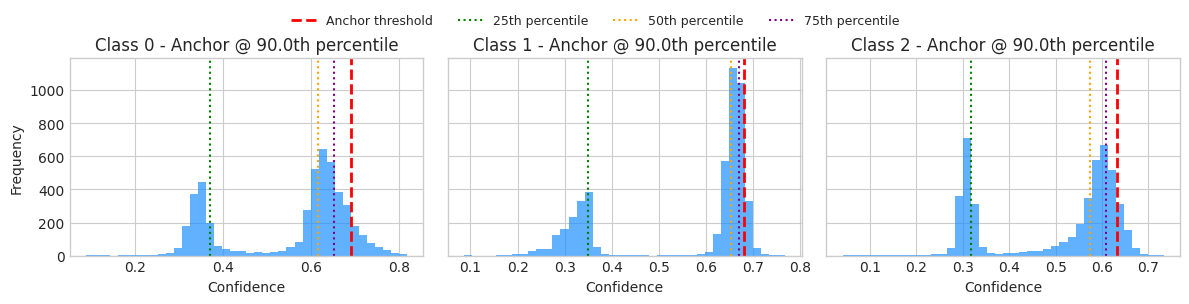


Estimated T (FashionMNIST0.3):
tensor([[0.73, 0.25, 0.03],
        [0.03, 0.69, 0.28],
        [0.31, 0.04, 0.65]])

Deviation from true T (FashionMNIST0.3):
tensor([[ 0.03, -0.05,  0.03],
        [ 0.03, -0.01, -0.02],
        [ 0.01,  0.04, -0.05]])

***FashionMNIST0.6
Epoch [6/30] — Loss: 1.0977 | Val Acc: 37.35% | eta: 0.000100
Early stopping triggered at epoch 9 — Loss: 1.0975 | Val Acc: 38.10% | eta: 0.000094
True class 0: 1420 anchors @ 70.0th percentile
True class 1: 956 anchors @ 80.0th percentile
True class 2: 1467 anchors @ 70.0th percentile


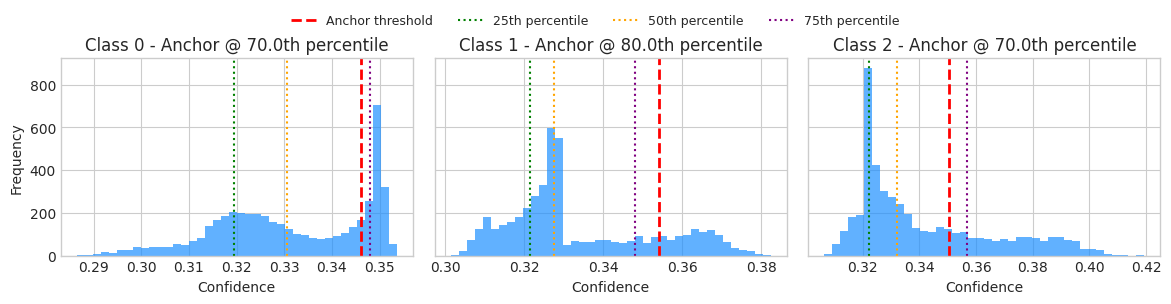


Estimated T (FashionMNIST0.6):
tensor([[0.35, 0.33, 0.32],
        [0.32, 0.36, 0.32],
        [0.31, 0.31, 0.37]])

Deviation from true T (FashionMNIST0.6):
tensor([[-0.05,  0.03,  0.02],
        [ 0.02, -0.04,  0.02],
        [ 0.01,  0.01, -0.03]])

***CIFAR
Epoch [6/30] — Loss: 1.1364 | Val Acc: 35.00% | eta: 0.000100
Early stopping triggered at epoch 7 — Loss: 1.1217 | Val Acc: 35.30% | eta: 0.000098
True class 0: 600 anchors @ 85.0th percentile
True class 1: 600 anchors @ 85.0th percentile
True class 2: 600 anchors @ 85.0th percentile


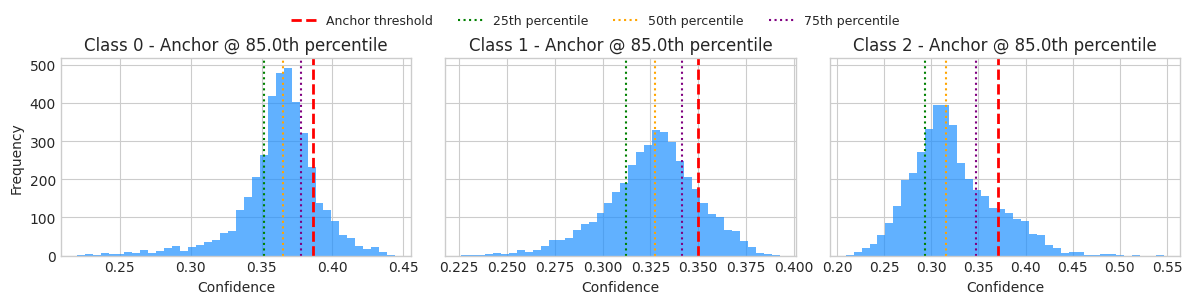


Estimated T (CIFAR):
tensor([[0.40, 0.33, 0.27],
        [0.37, 0.36, 0.27],
        [0.31, 0.29, 0.40]])


In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

torch.set_printoptions(precision=2, sci_mode=False)

def estimate_transition_matrix(
    model,
    dataloader,
    num_classes=3,
    min_percentiles=[],
    max_percentiles=[],
    verbose=True,
    visualize=False,
):
    """
    Estimate label transition matrix T (P(noisy=j | true=i)) using an adaptive anchor-point method.

    Each row T[i, :] represents the probability distribution over noisy labels j
    given the true label i.

    The method automatically determines a per-class confidence threshold (anchor percentile)
    based on the elbow point in each class’s predicted confidence distribution. This allows
    adapting to different noise levels per class.

    The inflection point where curve flattens is a good choice for anchor percentile

    Visual Strategy to choose min and max percentiles
    1. Identify the Distribution Pattern
    2. if Bimodal then keep range in the valley between the twin peaks
    3. if Unimodal - left/right skew (no clear separation for clean and noisy)
            if left skewed (Warning: weak anchor): keep range to the left of the peak
            if right skewed: keep range to the right of the peak

    Unimodal Label Noise:
        The noise follows a single-peaked (smooth) distribution — most samples have similar, moderate noise levels.
        Errors are evenly spread → models can still learn the dominant correct pattern.
        Learning is easier, since the model can gradually focus on the majority of clean samples.

    Bimodal Label Noise:
        The noise distribution has two peaks — some samples/classes are very clean, while others are very noisy.
        The model sees both reliable and unreliable patterns → it risks overfitting the noisy subset.

        Bimodal noise can make label cleaning easier — but only if the model’s confidence distribution cleanly
        separates true vs noisy labels. If the peaks overlap or the noise is confidently wrong, the transition
        matrix can be misled — making it look easier, but actually harder to correct properly.

    Args:
        model (torch.nn.Module): trained model on noisy data
        dataloader (DataLoader): data loader for dataset (X, noisy_y)
        num_classes (int): number of classes
        min_percentile (float): minimum allowable anchor percentile
        max_percentile (float): maximum allowable anchor percentile
        verbose (bool): if True, prints per-class thresholds and anchor stats
        visualize (bool): if True, plots confidence histograms per class

    Returns:
        torch.Tensor: estimated transition matrix T of shape [num_classes, num_classes]
                      where T[i, j] = P(noisy label=j | true label=i)
    """
    model.eval()  # disable dropout, batchnorm updates
    device = next(model.parameters()).device

    all_probs, all_labels = [], []

    # Collect predicted probabilities for all samples
    with torch.no_grad():
        for X, y in dataloader:
            logits = model(X)
            probs = F.softmax(logits, dim=1)  # predicted probabilities
            all_probs.append(probs.cpu())
            all_labels.append(y.cpu())

    all_probs = torch.cat(all_probs, dim=0)  # [N, num_classes]
    all_labels = torch.cat(all_labels, dim=0)  # [N]

    T_est = torch.zeros((num_classes, num_classes))  # transition matrix
    adaptive_pcts = {}

    # For visualization, collect confidences and thresholds
    all_confidences = []
    all_thresholds = []

    # Iterate over true label i (row of T)
    for i in range(num_classes):
        # Select samples where the model predicts i with high confidence
        class_mask = all_labels == i
        if class_mask.sum() == 0:
            if verbose:
                print(f"Warning: no samples for true class {i}")
            continue

        probs_i = all_probs[class_mask]  # [N_i, num_classes]
        confidences = probs_i[:, i]  # confidence for class i

        # Find the “elbow” in sorted confidences to select anchors
        sorted_conf, _ = torch.sort(confidences, descending=True)
        diffs = torch.diff(sorted_conf)     # measures how quickly confidence drops between consecutive samples
        if diffs.numel() > 0:
            elbow_idx = torch.argmin(diffs[int(0.5 * len(diffs)) :]) + int(
                0.5 * len(diffs)
            )
            elbow_percentile = 100 * (1 - elbow_idx / len(sorted_conf))
        else:
            elbow_percentile = max_percentiles[i]

        # Clamp percentile
        adaptive_pcts[i] = float(
            torch.clamp(
                elbow_percentile, min=min_percentiles[i], max=max_percentiles[i]
            )
        )

        # Compute threshold and select anchors
        threshold = torch.quantile(confidences, adaptive_pcts[i] / 100.0)
        anchor_mask = confidences >= threshold
        anchor_probs = probs_i[anchor_mask]

        # Fallback if no anchors found
        if anchor_probs.size(0) == 0:
            if verbose:
                print(
                    f"Warning: no anchors for true class {i}, using fallback {max_percentiles[i]}th percentile."
                )
            threshold = torch.quantile(confidences, max_percentiles[i] / 100.0)
            anchor_probs = probs_i[confidences >= threshold]

        # Compute row i of T: distribution over noisy labels j
        # T[i, j] = average predicted probability of noisy label j among anchors of true label i
        T_est[i] = anchor_probs.mean(dim=0)

        if visualize:
            all_confidences.append(confidences.numpy())
            all_thresholds.append(threshold.item())

        if verbose:
            print(
                f"True class {i}: {anchor_probs.size(0)} anchors @ {adaptive_pcts[i]:.1f}th percentile"
            )

    # Visualization: all histograms in a single row
    if visualize:
        fig, axes = plt.subplots(
            1, num_classes, figsize=(4 * num_classes, 3), sharey=True
        )
        for i, ax in enumerate(axes):
            if i < len(all_confidences):
                conf = all_confidences[i]
                ax.hist(conf, bins=40, color="#1E90FF", alpha=0.7)

                # Anchor threshold line
                ax.axvline(
                    all_thresholds[i],
                    color="red",
                    linestyle="--",
                    linewidth=2,
                    label="Anchor threshold" if i == 0 else "",
                )

                # Optional percentiles
                p25, p50, p75 = np.percentile(conf, [25, 50, 75])
                ax.axvline(
                    p25,
                    color="green",
                    linestyle=":",
                    linewidth=1.5,
                    label="25th percentile" if i == 0 else "",
                )
                ax.axvline(
                    p50,
                    color="orange",
                    linestyle=":",
                    linewidth=1.5,
                    label="50th percentile" if i == 0 else "",
                )
                ax.axvline(
                    p75,
                    color="purple",
                    linestyle=":",
                    linewidth=1.5,
                    label="75th percentile" if i == 0 else "",
                )

                ax.set_title(
                    f"Class {i} - Anchor @ {adaptive_pcts[i]:.1f}th percentile"
                )
                ax.set_xlabel("Confidence")
                if i == 0:
                    ax.set_ylabel("Frequency")

        # Single legend above all subplots
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(
            handles,
            labels,
            loc="upper center",
            ncol=4,
            fontsize=9,
            bbox_to_anchor=(0.5, 1.02),
            frameon=False,
        )

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # Normalize each row to make T a valid probability matrix
    T_est = T_est / T_est.sum(dim=1, keepdim=True)

    return T_est


# Training with uncorrected loss
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function with label smoothing (reduces overfitting)
ce_loss_w_smoothing = nn.CrossEntropyLoss(label_smoothing=0.1)

# fm3 80:20 stratified split for train/validation
print("\n***FashionMNIST0.3")
train_loader, val_loader, test_loader = create_dataloaders_stratified(
    Xtr_fm3_t, Str_fm3_t, Xts_fm3_t, Yts_fm3_t, val_split=0.2, batch_size=64, seed=42
)

model = SmallCNN(num_classes=3).to(device)  # For FashionMNIST3-class subset
model, _ = train_model(
    model,
    train_loader,
    val_loader,
    loss_fn=ce_loss_w_smoothing,
    num_epochs=30,
    warmup_epochs=5,
    eta=1e-4,
    eta_min=1e-6,
    patience=5,
)

# Transition Matrix Estimation
T_fm3_est = estimate_transition_matrix(
    model,
    train_loader,
    num_classes=3,
    min_percentiles=[90, 90, 90],
    max_percentiles=[99, 99, 99],
    visualize=True,
)
print("\nEstimated T (FashionMNIST0.3):")
print(T_fm3_est.round(decimals=2))
print("\nDeviation from true T (FashionMNIST0.3):")
print(T_fm3_est - T_fm3_t)

# fm6 80:20 stratified split for train/validation
print("\n***FashionMNIST0.6")
train_loader, val_loader, test_loader = create_dataloaders_stratified(
    Xtr_fm6_t, Str_fm6_t, Xts_fm6_t, Yts_fm6_t, val_split=0.2, batch_size=64, seed=42
)

model = SmallCNN(num_classes=3).to(device)  # For FashionMNIST6-class subset
model, _ = train_model(
    model,
    train_loader,
    val_loader,
    loss_fn=ce_loss_w_smoothing,
    num_epochs=30,
    warmup_epochs=5,
    eta=1e-4,
    eta_min=1e-6,
    patience=5,
)

# Transition Matrix Estimation
T_fm6_est = estimate_transition_matrix(
    model,
    train_loader,
    num_classes=3,
    min_percentiles=[70, 80, 70],
    max_percentiles=[75, 90, 80],
    visualize=True,
)
print("\nEstimated T (FashionMNIST0.6):")
print(T_fm6_est.round(decimals=2))
print("\nDeviation from true T (FashionMNIST0.6):")
print(T_fm6_est - T_fm6_t)

# cifar 80:20 stratified split for train/validation
print("\n***CIFAR")
train_loader, val_loader, test_loader = create_dataloaders_stratified(
    Xtr_cifar_t,
    Str_cifar_t,
    Xts_cifar_t,
    Yts_cifar_t,
    val_split=0.2,
    batch_size=64,
    seed=42,
)

model = SmallResNet(num_classes=3).to(device)  # For CIFAR-class subset
model, _ = train_model(
    model,
    train_loader,
    val_loader,
    loss_fn=ce_loss_w_smoothing,
    num_epochs=30,
    warmup_epochs=5,
    eta=1e-4,
    eta_min=1e-6,
    patience=5,
)

# Transition Matrix Estimation
T_cifar_est = estimate_transition_matrix(
    model,
    train_loader,
    num_classes=3,
    min_percentiles=[85, 85, 85],
    max_percentiles=[90, 90, 90],
    visualize=True,
)
print("\nEstimated T (CIFAR):")
print(T_cifar_est.round(decimals=2))

# Save T_cifar_est
torch.save(T_cifar_est, "T_cifar_est.pt")

### 3.1 Label Noise Transition Matrices

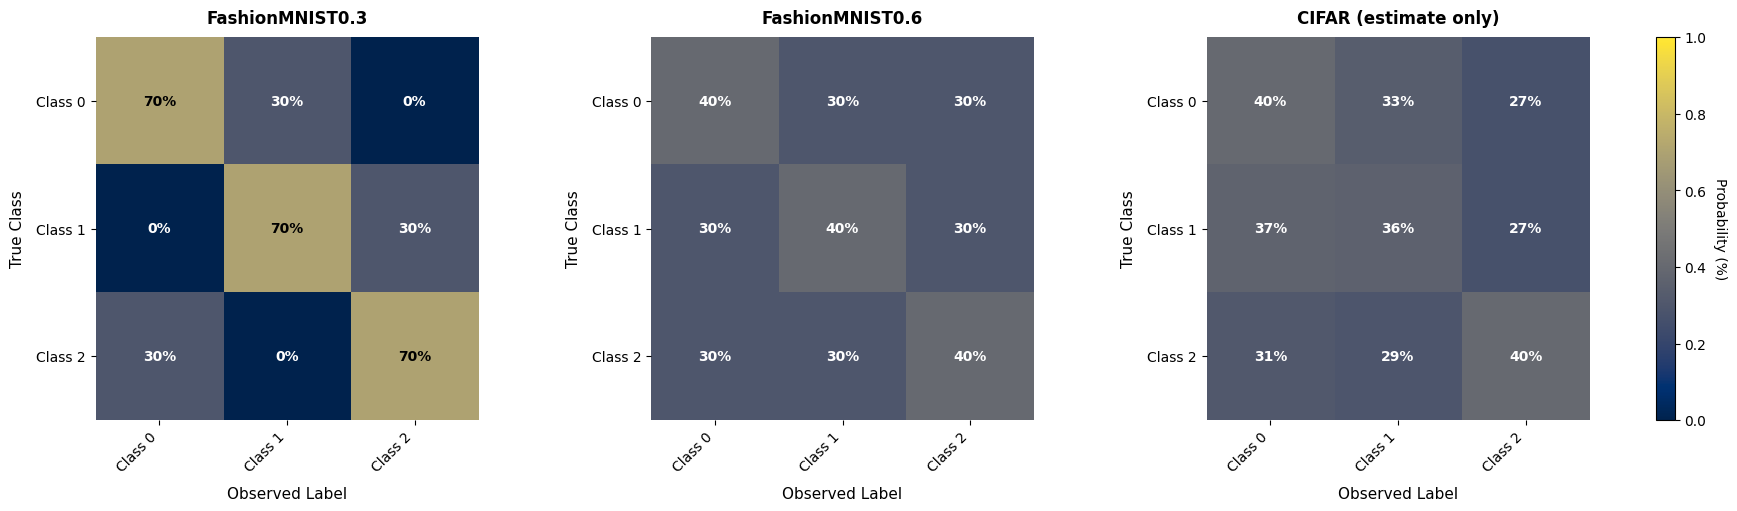

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

def visualize_transition_matrix_ax(
    ax, T, class_labels=None, title="Transition Matrix", cmap="cividis"
):
    if hasattr(T, "detach"):
        T = T.detach().cpu().numpy()
    num_classes = T.shape[0]

    # Display matrix
    im = ax.imshow(T, cmap=cmap, vmin=0, vmax=1, interpolation='nearest')

    # Annotate cells with percentage (dynamic text color)
    for i in range(num_classes):
        for j in range(num_classes):
            val = T[i, j] * 100
            # Choose black or white text depending on background brightness
            bg_color = im.cmap(T[i, j])
            brightness = 0.299*bg_color[0] + 0.587*bg_color[1] + 0.114*bg_color[2]  # perceived brightness
            text_color = "white" if brightness < 0.5 else "black"

            ax.text(
                j,
                i,
                f"{val:.0f}%",
                ha="center",
                va="center",
                color=text_color,
                fontsize=10,
                fontweight="bold",
            )

    # Class labels
    if class_labels is None:
        class_labels = [f"Class {i}" for i in range(num_classes)]
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_labels, rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(class_labels, fontsize=10)

    ax.set_xlabel("Observed Label", fontsize=11, labelpad=8)
    ax.set_ylabel("True Class", fontsize=11, labelpad=8)
    ax.set_title(title, pad=10, fontsize=12, fontweight="semibold")

    # Remove all grid lines and spines
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    return im

# Side-by-side figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

ims = [
    visualize_transition_matrix_ax(axes[0], T_fm3, title="FashionMNIST0.3"),
    visualize_transition_matrix_ax(axes[1], T_fm6, title="FashionMNIST0.6"),
    visualize_transition_matrix_ax(axes[2], T_cifar_est, title="CIFAR (estimate only)"),
]

# Shared colorbar
cbar = fig.colorbar(ims[0], ax=axes, orientation="vertical", fraction=0.025, pad=0.04)
cbar.set_label("Probability (%)", rotation=270, labelpad=15, fontsize=10)

plt.show()


### 3.2 Per Class Label Noise


=== Per-Class Label Noise ===

╒═══════════════════════╤═══════════╤═══════════╤═══════════╕
│ Dataset               │ Class 0   │ Class 1   │ Class 2   │
╞═══════════════════════╪═══════════╪═══════════╪═══════════╡
│ FashionMNIST0.3       │ 30.0%     │ 30.0%     │ 30.0%     │
├───────────────────────┼───────────┼───────────┼───────────┤
│ FashionMNIST0.6       │ 60.0%     │ 60.0%     │ 60.0%     │
├───────────────────────┼───────────┼───────────┼───────────┤
│ CIFAR (estimate only) │ 59.9%     │ 63.9%     │ 60.0%     │
╘═══════════════════════╧═══════════╧═══════════╧═══════════╛


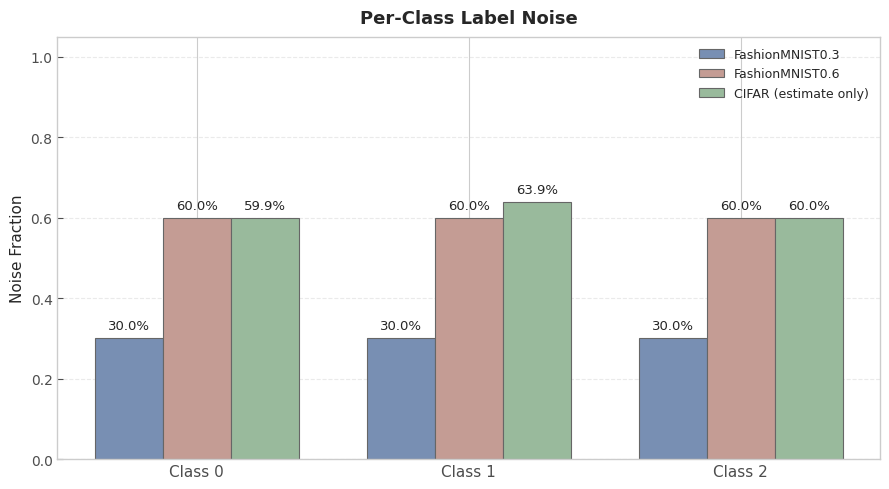

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

datasets = {
    "FashionMNIST0.3": T_fm3_t,
    "FashionMNIST0.6": T_fm6_t,
    "CIFAR (estimate only)": T_cifar_est
}

summary = []

for name, T in datasets.items():
    # Convert torch tensor (on GPU or CPU) to numpy
    if hasattr(T, "detach"):  
        T = T.detach().cpu().numpy()

    K = T.shape[0]
    assert T.shape[1] == K
    per_class_clean = np.diag(T)
    per_class_noise = 1.0 - per_class_clean
    summary.append([name] + list(per_class_noise))  # keep numeric

df_noise = pd.DataFrame(summary, columns=["Dataset"] + [f"Class {i}" for i in range(K)])
df_noise.set_index("Dataset", inplace=True)

print("\n=== Per-Class Label Noise ===\n")
df_display = df_noise.copy()

# Convert all numeric columns to formatted percentages
for col in df_display.columns:
    df_display[col] = df_display[col].astype(float).map(lambda x: f"{x*100:.1f}%")

print(tabulate(df_display.reset_index(), headers='keys', tablefmt='fancy_grid', showindex=False))

# Visualization
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(9, 5))

num_datasets = len(df_noise)
bar_width = 0.25
x = np.arange(K)

# Muted, color palette
muted_colors = [
    (0.47, 0.56, 0.70),  # soft blue-gray
    (0.77, 0.61, 0.58),  # muted red
    (0.60, 0.73, 0.61)   # muted green
]

# Bar plot
for i, (dataset, row) in enumerate(df_noise.iterrows()):
    noise_values = row.values.astype(float)  # ✅ only numeric values now
    bars = ax.bar(
        x + i * bar_width,
        noise_values,
        width=bar_width,
        label=dataset,
        color=muted_colors[i % len(muted_colors)],
        edgecolor="0.4",
        linewidth=0.8
    )

    # Add percentage labels
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.015,
            f"{height*100:.1f}%",
            ha='center',
            va='bottom',
            fontsize=9.5,
            color='0.15'
        )

# --- Axis & Styling ---
ax.set_xticks(x + bar_width * (num_datasets - 1) / 2)
ax.set_xticklabels([f"Class {i}" for i in range(K)], fontsize=11)

ax.set_ylabel("Noise Fraction", fontsize=11)
ax.set_title("Per-Class Label Noise", fontsize=13, fontweight='semibold', pad=10)
ax.legend(frameon=False, fontsize=9, title_fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.set_axisbelow(True)
ax.tick_params(direction='in', length=4, width=0.8, colors='0.3')
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()


## 4 Robust Noisy Label Correction Methods

### 4.0 Classifier 1: Cross-Entropy with Noise Correction (Forward Learning)

In [15]:
import torch

def forward_learning(logits, y_true, T):
    """
    Compute the Forward-Corrected Cross-Entropy Loss
    for learning with noisy labels.

    Args:
        logits: Tensor of shape [batch_size, num_classes]
                Raw outputs from the model (before softmax).
        y_true: Tensor of shape [batch_size]
                Noisy labels (integers in {0, 1, 2, ...}).
        T:      Tensor of shape [num_classes, num_classes]
                Transition matrix where T[i, j] = P(noisy_label=j | true_label=i).

    Returns:
        loss: scalar tensor — the average forward-corrected loss over the batch.
    """

    # Convert logits to probabilities using softmax
    probs = torch.softmax(logits, dim=1)  # shape: [batch_size, num_classes]

    # Map clean label probabilities to noisy label probabilities using T (Forward Correction)
    corrected_probs = probs @ T  # corrected_probs[i, j] = P(noisy_label=j | x_i)

    # Convert corrected probabilities to log-probabilities in a numerically stable way
    logp = torch.log(corrected_probs + 1e-12)

    # Negative Log Likelihood with noisy labels
    loss = torch.nn.functional.nll_loss(logp, y_true)

    # Return mean loss over the batch
    return loss

### 4.1 Classifier 2: Co-teaching

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def coteaching(
    model1,
    model2,
    train_loader,
    val_loader,
    loss_fn=None,
    forget_rate=0.4,
    num_gradual=10,
    disagreement_weight=0.01,
    num_epochs=50,
    warmup_epochs=3,
    eta=1e-3,
    eta_min=1e-5,
    patience=3,
    verbose=True,
):
    """
    Train two neural networks jointly using the Co-Teaching algorithm for robust learning under noisy labels.

    This function implements a stable version of the Co-Teaching approach, where
    two networks are trained simultaneously and exchange small-loss samples to
    mitigate the effect of label noise. It includes:
      • Linear "remember rate" — gradually decreasing the proportion
        of samples used for updates.
      • Linear learning rate warmup followed by cosine annealing for smooth
        convergence.
      • Symmetric training where each model teaches the other using samples
        it believes are clean (low-loss).
      • Early stopping placeholder for future stability extensions.

    Args:
        model1 (nn.Module):
            First neural network model to be co-trained.

        model2 (nn.Module):
            Second neural network model to be co-trained.

        train_loader (DataLoader):
            DataLoader providing training batches of (inputs, labels).

        val_loader (DataLoader):
            DataLoader providing validation data for monitoring performance.

        loss_fn (callable, optional):
            Loss function used for training, typically
            `nn.CrossEntropyLoss(reduction='none')` to compute per-sample losses.

        forget_rate (float, default=0.4):
            forget_rate = 0.4 → means each network ignores 40% of samples at peak forgetting.
            With 60% noise, the expected clean fraction = 1 − 0.8 = 0.2.
            We ideally want the networks to keep only the clean fraction at the end.

        num_gradual (int, default=10):
            number of epochs over which forget_rate ramps up.
            A slower ramp can help stabilize learning early.

        disagreement_weight (float, default=0.01):
            Scaling factor for emphasizing samples on which the two models disagree. 
            Higher values increase emphasis on disagreement-driven learning.

        num_epochs (int, default=50):
            Maximum number of epochs for training.

        warmup_epochs (int, default=3):
            Networks get some initial alignment before aggressive filtering.

        eta (float, default=1e-3):
            Initial (maximum) learning rate before cosine annealing.

        eta_min (float, default=1e-5):
            Minimum learning rate during cosine annealing.

        patience (int, default=3):
            Delay early stopping (half the total epochs, is a reasonable option)

        verbose (bool, default=True):
            If True, prints training progress and epoch-level summaries.

    Returns:
        tuple[nn.Module, nn.Module]:
            The two co-trained models (`model1`, `model2`) after training completion.
        history (dict): 
            Dictionary containing training history.
    """

    # For visualization
    history = {
        'epoch': [],
        'loss1': [], 'loss2': [],
        'val_acc1': [], 'val_acc2': [],
        'remember_rate': []
    }

    # Initialize optimizers
    optimizer1 = optim.Adam(
        model1.parameters(), lr=eta, weight_decay=1e-4
    )  # weight_decay, L2 regularization
    optimizer2 = optim.Adam(
        model2.parameters(), lr=eta, weight_decay=1e-4
    )  # weight_decay, L2 regularization

    # Linear warm-up scheduler
    warmup_scheduler1 = torch.optim.lr_scheduler.LinearLR(
        optimizer1, start_factor=1e-3, end_factor=1.0, total_iters=warmup_epochs
    )
    warmup_scheduler2 = torch.optim.lr_scheduler.LinearLR(
        optimizer2, start_factor=1e-3, end_factor=1.0, total_iters=warmup_epochs
    )

    # Cosine annealing scheduler for the rest of training
    cosine_scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer1, T_max=(num_epochs - warmup_epochs), eta_min=eta_min
    )
    cosine_scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer2, T_max=(num_epochs - warmup_epochs), eta_min=eta_min
    )

    # Combine both schedulers
    scheduler1 = torch.optim.lr_scheduler.SequentialLR(
        optimizer1,
        schedulers=[warmup_scheduler1, cosine_scheduler1],
        milestones=[warmup_epochs],
    )
    scheduler2 = torch.optim.lr_scheduler.SequentialLR(
        optimizer2,
        schedulers=[warmup_scheduler2, cosine_scheduler2],
        milestones=[warmup_epochs],
    )

    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_wts1 = model1.state_dict()
    best_model_wts2 = model2.state_dict()

    disagreements = []

    for epoch in range(num_epochs):
        model1.train()
        model2.train()

        # Co-Teaching remember rate: R(T) = 1 - min(T / Tk, 1) * forget_rate
        T = epoch + 1
        Tk = num_gradual
        remember_rate = 1.0 - min(T / Tk, 1.0) * forget_rate

        total_loss1, total_loss2 = 0.0, 0.0

        for X, y in train_loader:

            # Forward passes
            out1 = model1(X)
            out2 = model2(X)

            # Per-sample losses
            losses1 = loss_fn(out1, y)
            losses2 = loss_fn(out2, y)

            # Disagreement-based weighting 
            pred1 = torch.argmax(out1, dim=1)
            pred2 = torch.argmax(out2, dim=1)
            disagreement = (pred1 != pred2).float()
            disagreements.append(disagreement.mean().item())
                
            # Weight losses by disagreement
            weighted_losses1 = losses1 * (1 + disagreement_weight * disagreement)
            weighted_losses2 = losses2 * (1 + disagreement_weight * disagreement)
                
            idx1 = torch.argsort(weighted_losses1)
            idx2 = torch.argsort(weighted_losses2)

            # Sort samples by loss (ascending - small loss first)
            # idx1 = torch.argsort(losses1)
            # idx2 = torch.argsort(losses2)

            # Select small-loss instances
            remember_size = int(remember_rate * len(losses1))
            remember_size = max(1, remember_size)  # avoid zero

            idx1_update = idx1[:remember_size]
            idx2_update = idx2[:remember_size]

            # Cross-update: model1 learns from model2's selection, vice versa
            # Each model updates its weights using the cleanest samples as judged by the other model,
            # which helps filter out mislabeled/noisy data and stabilizes learning.
            loss1_update = torch.mean(losses1[idx2_update])
            loss2_update = torch.mean(losses2[idx1_update])

            # Zero gradients
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            # Backward and update
            loss1_update.backward()
            loss2_update.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=5.0)
            torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=5.0)

            # Optimizer step
            optimizer1.step()
            optimizer2.step()

            total_loss1 += loss1_update.item() * X.size(0)
            total_loss2 += loss2_update.item() * X.size(0)

        # Calculate epoch losses
        epoch_loss1 = total_loss1 / len(train_loader.dataset)
        epoch_loss2 = total_loss2 / len(train_loader.dataset)

        # Validation
        model1.eval()
        model2.eval()
        val_correct1, val_correct2, val_total = 0, 0, 0

        with torch.no_grad():
            for X, y in val_loader:

                out1 = model1(X)
                out2 = model2(X)

                pred1 = torch.argmax(out1, dim=1)
                pred2 = torch.argmax(out2, dim=1)

                val_correct1 += (pred1 == y).sum().item()
                val_correct2 += (pred2 == y).sum().item()
                val_total += y.size(0)

        val_acc1 = 100 * val_correct1 / val_total
        val_acc2 = 100 * val_correct2 / val_total
        avg_val_acc = (val_acc1 + val_acc2) / 2

        scheduler1.step()
        scheduler2.step()

        # Early stopping
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            epochs_no_improve = 0
            # Save the best model weights
            best_model_wts1 = model1.state_dict()
            best_model_wts2 = model2.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            if verbose:
                print(
                    f"Early stopping triggered at epoch {epoch+1} — "
                    f"Loss1: {epoch_loss1:.4f} | Loss2: {epoch_loss2:.4f} | "
                    f"AvgValAcc={avg_val_acc:.2f}% | Remember Rate: {remember_rate:.2f} | "
                    f"eta={optimizer1.param_groups[0]['lr']:.2e}"
                )
                break

        # Print progress
        if verbose and (epoch + 1) % max(1, num_epochs // 10) == 0:
            print(
                f"[Epoch {epoch+1}/{num_epochs}] "
                f"Loss1={epoch_loss1:.4f} | Loss2={epoch_loss2:.4f} | "
                f"AvgValAcc={avg_val_acc:.2f}% | RememberRate={remember_rate:.2f} "
                f"| eta={optimizer1.param_groups[0]['lr']:.2e}"
            )
        
        history['epoch'].append(epoch)
        history['remember_rate'].append(remember_rate)
        history['loss1'].append(epoch_loss1)
        history['val_acc1'].append(val_acc1)
        history['loss2'].append(epoch_loss2)
        history['val_acc2'].append(val_acc2)

    # Load best model weights
    model1.load_state_dict(best_model_wts1)
    model2.load_state_dict(best_model_wts2)

    return model1, model2, history

### 4.1a Symmetric Cross-Entropy (SCE) loss function - for use in Coteaching

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SymmetricCrossEntropyLoss(nn.Module):
    """
    Symmetric Cross-Entropy Loss (SCE) for robust learning under noisy labels.

    SCE combines the standard Cross-Entropy (CE) loss with a Reverse Cross-Entropy (RCE)
    term to improve robustness when training on datasets with label noise.

    Formula:
        L_SCE = alpha * CE + beta * RCE
        where:
            CE  = -sum(y * log(p))          (standard cross-entropy)
            RCE = -sum(p * log(y))          (reverse cross-entropy)
            y   = one-hot encoded true labels
            p   = predicted probabilities from the model

    Intuition:
        - CE encourages the model to fit the labels.
        - RCE penalizes overconfident predictions on potentially incorrect labels,
          reducing the impact of noisy labels.
        - Combined, SCE stabilizes training, particularly in high-noise regimes.

    Benefits in Co-Teaching:
        - Co-Teaching already selects small-loss samples to filter out noisy labels.
        - Using SCE further mitigates the effect of any noisy samples that remain in the
          training batch, improving convergence and ensemble accuracy.
        - Particularly effective for datasets with high label noise (e.g., 50-60%).

    Args:
        alpha (float, default=1.0):
            Weight for the standard Cross-Entropy term.
        beta (float, default=0.1):
            Weight for the Reverse Cross-Entropy term.
        num_classes (int, default=10):
            Number of classes in the dataset (needed for one-hot encoding).

    Inputs:
        logits: torch.Tensor of shape [batch_size, num_classes]
            Raw model outputs (before softmax).
        targets: torch.Tensor of shape [batch_size]
            Integer class labels.

    Returns:
        loss: torch.Tensor of shape [batch_size]
            Per-sample symmetric cross-entropy losses. Can be used directly in Co-Teaching
            (with reduction='none') for small-loss selection.

    Example:
        loss_fn = SymmetricCrossEntropyLoss(alpha=1.0, beta=0.1, num_classes=10)
        loss = loss_fn(logits, targets)
    """
    def __init__(self, alpha=1.0, beta=0.1, num_classes=10):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes

    def forward(self, logits, targets):
        """
        logits: [batch_size, num_classes]
        targets: [batch_size] (class indices)
        """
        # Standard CE
        ce = F.cross_entropy(logits, targets, reduction='none')

        # One-hot encoding
        y_onehot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Probabilities
        p = F.softmax(logits, dim=1)

        # Reverse CE
        rce = -torch.sum(p * torch.log(y_onehot + 1e-6), dim=1)

        # Combine
        loss = self.alpha * ce + self.beta * rce
        return loss


## 5 Training, Testing & Repetition

### 5.0 One Split

In [56]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

torch.set_printoptions(precision=2, sci_mode=False)

num_runs = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T_cifar_est = torch.load("T_cifar_est.pt").to(device)

# Original CE with label smoothing
# ce_loss_w_smoothing_no_reduction = nn.CrossEntropyLoss(
#     label_smoothing=0.1, reduction="none"
# )

# Symmetric Cross-Entropy Loss
sce_loss = SymmetricCrossEntropyLoss(alpha=1.0, beta=0.1, num_classes=3)

for i in range(num_runs):

    np.random.seed(i)  # for replicability
    torch.manual_seed(i)

    # -----------------
    # Forward Learning
    # -----------------

    # fm3 80:20 stratified split, forward learning
    print("\n***FashionMNIST0.3 - Forward Learning")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_fm3_t, Str_fm3_t, Xts_fm3_t, Yts_fm3_t, val_split=0.2, batch_size=64, seed=i
    )

    model = SmallCNN(num_classes=3).to(device)  # For FashionMNIST3-class subset
    model, _ = train_model(
        model,
        train_loader,
        val_loader,
        loss_fn=forward_learning,
        T=T_fm3_t,
        num_epochs=10,
        warmup_epochs=5,
        eta=1e-3,
        eta_min=1e-5,
        patience=5,
    )
    accuracy = compute_top1_accuracy(model, test_loader)
    print(f"Top-1 accuracy: {accuracy:.2f}%")

    # fm6 80:20 stratified split, forward learning
    print("\n***FashionMNIST0.6 - Forward Learning")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_fm6_t, 
        Str_fm6_t, 
        Xts_fm6_t, 
        Yts_fm6_t, 
        val_split=0.2, 
        batch_size=64, 
        seed=i,
    )

    model = SmallCNN(num_classes=3).to(device)  # For FashionMNIST6-class subset
    model, _ = train_model(
        model,
        train_loader,
        val_loader,
        loss_fn=forward_learning,
        T=T_fm6_t,
        num_epochs=10,
        warmup_epochs=5,
        eta=1e-4,
        eta_min=1e-6,
        patience=5,
    )
    accuracy = compute_top1_accuracy(model, test_loader)
    print(f"Top-1 accuracy: {accuracy:.2f}%")

    # cifar 80:20 stratified split, forward learning
    print("\n***CIFAR - Forward Learning")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_cifar_t,
        Str_cifar_t,
        Xts_cifar_t,
        Yts_cifar_t,
        val_split=0.2,
        batch_size=64,
        seed=i,
    )

    model = SmallResNet(num_classes=3).to(device)  # For CIFAR-class subset
    model, _ = train_model(
        model,
        train_loader,
        val_loader,
        loss_fn=forward_learning,
        T=T_cifar_est,
        num_epochs=20,
        warmup_epochs=5,
        eta=1e-3,
        eta_min=1e-5,
        patience=5,
    )
    accuracy = compute_top1_accuracy(model, test_loader)
    print(f"Top-1 accuracy: {accuracy:.2f}%")

    # -----------------
    # Coteaching
    # -----------------

    # fm3 80:20 stratified split, Coteaching
    print("\n***FashionMNIST0.3 - Coteaching")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_fm3_t, 
        Str_fm3_t, 
        Xts_fm3_t, 
        Yts_fm3_t, 
        val_split=0.2, 
        batch_size=64, 
        seed=i,
    )

    # Initialize two models
    model1 = SmallCNN(num_classes=3).to(device)  # For FashionMNIST3-class subset
    model2 = SmallCNN(num_classes=3).to(device)  # For FashionMNIST3-class subset

    model1, model2, _ = coteaching(
        model1,
        model2,
        train_loader,
        val_loader,
        loss_fn=sce_loss,
        forget_rate=0.2,
        num_gradual=8,
        disagreement_weight=0.1,
        num_epochs=10,
        warmup_epochs=3,
        eta=1e-3,
        eta_min=1e-4,
        patience=3,
    )

    ensemble_acc = compute_ensemble_top1_accuracy(model1, model2, test_loader)
    print(f"Ensemble Top-1 accuracy: {ensemble_acc:.2f}%")

    # fm6 80:20 stratified split, Coteaching
    print("\n***FashionMNIST0.6 - Coteaching")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_fm6_t, 
        Str_fm6_t, Xts_fm6_t, 
        Yts_fm6_t, 
        val_split=0.2, 
        batch_size=64, 
        seed=i,
    )

    # Initialize two models
    model1 = SmallCNN(num_classes=3).to(device)  # For FashionMNIST6-class subset
    model2 = SmallCNN(num_classes=3).to(device)  # For FashionMNIST6-class subset

    model1, model2, _ = coteaching(
        model1,
        model2,
        train_loader,
        val_loader,
        loss_fn=sce_loss,
        forget_rate=0.5,
        num_gradual=8,
        disagreement_weight=0.05,
        num_epochs=10,
        warmup_epochs=3,
        eta=5e-4,
        eta_min=5e-6,
        patience=5,
    )

    ensemble_acc = compute_ensemble_top1_accuracy(model1, model2, test_loader)
    print(f"Ensemble Top-1 accuracy: {ensemble_acc:.2f}%")

    # cifar 80:20 stratified split, Coteaching
    print("\n***CIFAR - Coteaching")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_cifar_t,
        Str_cifar_t,
        Xts_cifar_t,
        Yts_cifar_t,
        val_split=0.2,
        batch_size=64,
        seed=i,
    )

    # Initialize two models
    model1 = SmallResNet(num_classes=3).to(device)  # For CIFAR-class subset
    model2 = SmallResNet(num_classes=3).to(device)  # For CIFAR-class subset

    model1, model2, _ = coteaching(
        model1,
        model2,
        train_loader,
        val_loader,
        loss_fn=sce_loss,
        forget_rate=0.4,
        num_gradual=10,
        disagreement_weight=0.05,
        num_epochs=20,
        warmup_epochs=10,
        eta=1e-4,
        eta_min=1e-6,
        patience=10,
    )

    ensemble_acc = compute_ensemble_top1_accuracy(model1, model2, test_loader)
    print(f"Ensemble Top-1 accuracy: {ensemble_acc:.2f}%")


***FashionMNIST0.3 - Forward Learning
Epoch [2/10] — Loss: 0.6796 | Val Acc: 67.87% | eta: 0.000401
Epoch [4/10] — Loss: 0.6516 | Val Acc: 68.23% | eta: 0.000800
Epoch [6/10] — Loss: 0.6441 | Val Acc: 68.51% | eta: 0.000905
Epoch [8/10] — Loss: 0.6297 | Val Acc: 68.73% | eta: 0.000352
Epoch [10/10] — Loss: 0.6205 | Val Acc: 68.79% | eta: 0.000010
Top-1 accuracy: 99.10%

***FashionMNIST0.6 - Forward Learning
Epoch [2/10] — Loss: 1.0972 | Val Acc: 36.05% | eta: 0.000040
Epoch [4/10] — Loss: 1.0930 | Val Acc: 37.91% | eta: 0.000080
Epoch [6/10] — Loss: 1.0916 | Val Acc: 38.38% | eta: 0.000091


KeyboardInterrupt: 

### 5.1 Ten Splits

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import csv
import statistics

# Define results dict reflecting final CSV structure
results = {
    "FashionMNIST0.3_Forward": [],
    "FashionMNIST0.6_Forward": [],
    "CIFAR_Forward": [],
    "FashionMNIST0.3_Coteaching": [],
    "FashionMNIST0.6_Coteaching": [],
    "CIFAR_Coteaching": [],
}

torch.set_printoptions(precision=2, sci_mode=False)

num_runs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T_cifar_est = torch.load("T_cifar_est.pt").to(device)

# Original CE with label smoothing
# ce_loss_w_smoothing_no_reduction = nn.CrossEntropyLoss(
#     label_smoothing=0.1, reduction="none"
# )

# Symmetric Cross-Entropy Loss
sce_loss = SymmetricCrossEntropyLoss(alpha=1.0, beta=0.1, num_classes=3)

for i in range(num_runs):

    print(f"\n***Iteration {i+1}")

    np.random.seed(i)  # for replicability
    torch.manual_seed(i)

    # -----------------
    # Forward Learning
    # -----------------

    # fm3 80:20 stratified split, forward learning
    print("\n***FashionMNIST0.3 - Forward Learning")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_fm3_t, Str_fm3_t, Xts_fm3_t, Yts_fm3_t, val_split=0.2, batch_size=64, seed=i
    )

    model = SmallCNN(num_classes=3).to(device)  # For FashionMNIST3-class subset
    model, _ = train_model(
        model,
        train_loader,
        val_loader,
        loss_fn=forward_learning,
        T=T_fm3_t,
        num_epochs=10,
        warmup_epochs=5,
        eta=1e-3,
        eta_min=1e-5,
        patience=5,
        verbose=False,
    )
    accuracy = compute_top1_accuracy(model, test_loader)
    print(f"Top-1 accuracy: {accuracy:.2f}%")
    results["FashionMNIST0.3_Forward"].append(accuracy)

    # fm6 80:20 stratified split, forward learning
    print("\n***FashionMNIST0.6 - Forward Learning")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_fm6_t, Str_fm6_t, Xts_fm6_t, Yts_fm6_t, val_split=0.2, batch_size=64, seed=i
    )

    model = SmallCNN(num_classes=3).to(device)  # For FashionMNIST6-class subset
    model, _ = train_model(
        model,
        train_loader,
        val_loader,
        loss_fn=forward_learning,
        T=T_fm6_t,
        num_epochs=10,
        warmup_epochs=5,
        eta=1e-4,
        eta_min=1e-6,
        patience=5,
        verbose=False,
    )
    accuracy = compute_top1_accuracy(model, test_loader)
    print(f"Top-1 accuracy: {accuracy:.2f}%")
    results["FashionMNIST0.6_Forward"].append(accuracy)

    # cifar 80:20 stratified split, forward learning
    print("\n***CIFAR - Forward Learning")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_cifar_t,
        Str_cifar_t,
        Xts_cifar_t,
        Yts_cifar_t,
        val_split=0.2,
        batch_size=64,
        seed=i,
    )

    model = SmallResNet(num_classes=3).to(device)  # For CIFAR-class subset
    model, _ = train_model(
        model,
        train_loader,
        val_loader,
        loss_fn=forward_learning,
        T=T_cifar_est,
        num_epochs=20,
        warmup_epochs=5,
        eta=1e-3,
        eta_min=1e-5,
        patience=5,
        verbose=False,
    )
    accuracy = compute_top1_accuracy(model, test_loader)
    print(f"Top-1 accuracy: {accuracy:.2f}%")
    results["CIFAR_Forward"].append(accuracy)

    # -----------------
    # Coteaching
    # -----------------

    # fm3 80:20 stratified split, Coteaching
    print("\n***FashionMNIST0.3 - Coteaching")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_fm3_t, Str_fm3_t, Xts_fm3_t, Yts_fm3_t, val_split=0.2, batch_size=64, seed=i
    )

    # Initialize two models
    model1 = SmallCNN(num_classes=3).to(device)  # For FashionMNIST3-class subset
    model2 = SmallCNN(num_classes=3).to(device)  # For FashionMNIST3-class subset

    model1, model2, _ = coteaching(
        model1,
        model2,
        train_loader,
        val_loader,
        loss_fn=sce_loss,
        forget_rate=0.2,
        num_gradual=8,
        disagreement_weight=0.1,
        num_epochs=10,
        warmup_epochs=3,
        eta=1e-3,
        eta_min=1e-4,
        patience=3,
        verbose=False,
    )

    ensemble_acc = compute_ensemble_top1_accuracy(model1, model2, test_loader)
    print(f"Ensemble Top-1 accuracy: {ensemble_acc:.2f}%")
    results["FashionMNIST0.3_Coteaching"].append(ensemble_acc)

    # fm6 80:20 stratified split, Coteaching
    print("\n***FashionMNIST0.6 - Coteaching")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_fm6_t, Str_fm6_t, Xts_fm6_t, Yts_fm6_t, val_split=0.2, batch_size=64, seed=i
    )

    # Initialize two models
    model1 = SmallCNN(num_classes=3).to(device)  # For FashionMNIST6-class subset
    model2 = SmallCNN(num_classes=3).to(device)  # For FashionMNIST6-class subset

    model1, model2, _ = coteaching(
        model1,
        model2,
        train_loader,
        val_loader,
        loss_fn=sce_loss,
        forget_rate=0.5,
        num_gradual=8,
        disagreement_weight=0.05,
        num_epochs=10,
        warmup_epochs=3,
        eta=5e-4,
        eta_min=5e-6,
        patience=5,
        verbose=False,
    )

    ensemble_acc = compute_ensemble_top1_accuracy(model1, model2, test_loader)
    print(f"Ensemble Top-1 accuracy: {ensemble_acc:.2f}%")
    results["FashionMNIST0.6_Coteaching"].append(ensemble_acc)

    # cifar 80:20 stratified split, Coteaching
    print("\n***CIFAR - Coteaching")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_cifar_t,
        Str_cifar_t,
        Xts_cifar_t,
        Yts_cifar_t,
        val_split=0.2,
        batch_size=64,
        seed=i,
    )

    # Initialize two models
    model1 = SmallResNet(num_classes=3).to(device)  # For CIFAR-class subset
    model2 = SmallResNet(num_classes=3).to(device)  # For CIFAR-class subset

    model1, model2, _ = coteaching(
        model1,
        model2,
        train_loader,
        val_loader,
        loss_fn=sce_loss,
        forget_rate=0.4,
        num_gradual=10,
        disagreement_weight=0.05,
        num_epochs=20,
        warmup_epochs=10,
        eta=1e-4,
        eta_min=1e-6,
        patience=10,
        verbose=False,
    )

    ensemble_acc = compute_ensemble_top1_accuracy(model1, model2, test_loader)
    print(f"Ensemble Top-1 accuracy: {ensemble_acc:.2f}%")
    results["CIFAR_Coteaching"].append(ensemble_acc)

    # Compute summary statistics
    summary = []
    for key, values in results.items():
        mean_acc = statistics.mean(values)
        std_acc = statistics.stdev(values) if len(values) > 1 else 0.0
        summary.append({
            "Experiment": key,
            "Mean_Top1_Accuracy": round(mean_acc, 2),
            "Std_Top1_Accuracy": round(std_acc, 2),
            "All_Runs": [round(v, 2) for v in values]
        })

# Display using tabulate
print("\n=== Summary of Results ===")
print(tabulate(summary, headers="keys", tablefmt="fancy_grid", showindex=False, floatfmt=".2f"))

# Save to CSV
csv_file = "top1_accuracy_results.csv"
with open(csv_file, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["Experiment", "Mean_Top1_Accuracy", "Std_Top1_Accuracy", "All_Runs"])
    writer.writeheader()
    writer.writerows(summary)

print(f"\nResults saved to {csv_file}")



***FashionMNIST0.3 - Forward Learning
Epoch [2/10] — Loss: 0.6796 | Val Acc: 67.87% | eta: 0.000401
Epoch [4/10] — Loss: 0.6516 | Val Acc: 68.23% | eta: 0.000800
Epoch [6/10] — Loss: 0.6441 | Val Acc: 68.51% | eta: 0.000905
Epoch [8/10] — Loss: 0.6297 | Val Acc: 68.73% | eta: 0.000352
Epoch [10/10] — Loss: 0.6205 | Val Acc: 68.79% | eta: 0.000010
Top-1 accuracy: 99.10%

***FashionMNIST0.6 - Forward Learning
Epoch [2/10] — Loss: 1.0972 | Val Acc: 36.05% | eta: 0.000040
Epoch [4/10] — Loss: 1.0930 | Val Acc: 37.91% | eta: 0.000080
Epoch [6/10] — Loss: 1.0916 | Val Acc: 38.38% | eta: 0.000091
Early stopping triggered at epoch 8 — Loss: 1.0914 | Val Acc: 38.16% | eta: 0.000035
Top-1 accuracy: 95.67%

***CIFAR - Forward Learning
Epoch [4/20] — Loss: 1.0964 | Val Acc: 35.83% | eta: 0.000800
Epoch [8/20] — Loss: 1.0960 | Val Acc: 36.70% | eta: 0.000905
Epoch [12/20] — Loss: 1.0951 | Val Acc: 36.40% | eta: 0.000557
Early stopping triggered at epoch 13 — Loss: 1.0953 | Val Acc: 36.60% | eta: 0

## 6 Quick Tuning

### 6.0 Forward Learning


***CIFAR - Forward Learning
Epoch [4/20] — Loss: 1.0964 | Val Acc: 35.83% | eta: 0.000800
Epoch [8/20] — Loss: 1.0960 | Val Acc: 36.70% | eta: 0.000905
Early stopping triggered at epoch 11 — Loss: 1.0949 | Val Acc: 36.30% | eta: 0.000658
Top-1 accuracy: 43.57%


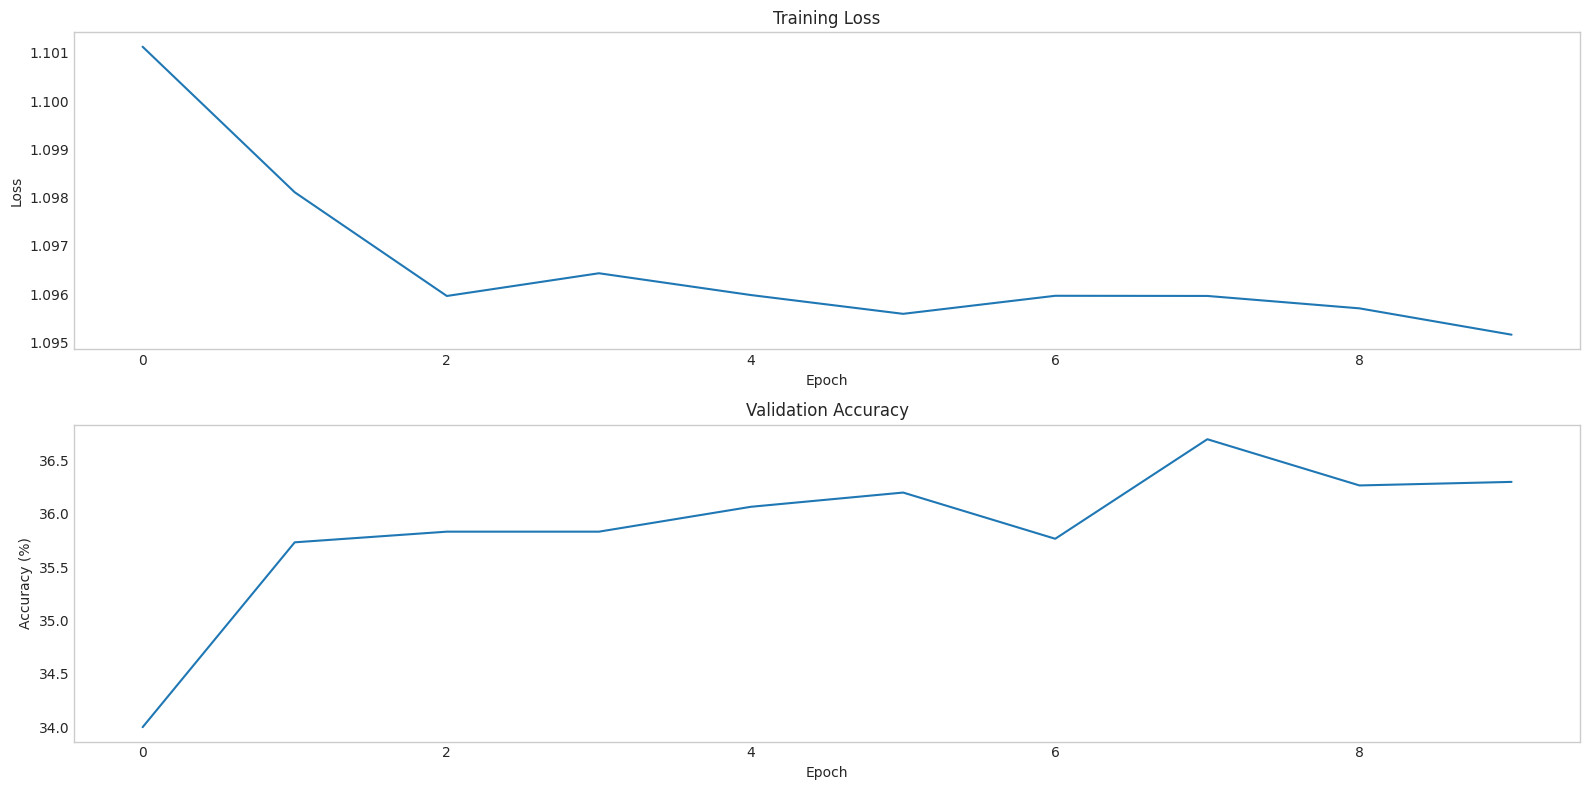

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.set_printoptions(precision=2, sci_mode=False)

num_runs = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T_cifar_est = torch.load("T_cifar_est.pt").to(device)

for i in range(num_runs):

    np.random.seed(i)  # for replicability
    torch.manual_seed(i)

    # cifar 80:20 stratified split, forward learning
    print("\n***CIFAR - Forward Learning")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_cifar_t,
        Str_cifar_t,
        Xts_cifar_t,
        Yts_cifar_t,
        val_split=0.2,
        batch_size=64,
        seed=i,
    )

    model = SmallResNet(num_classes=3).to(device)  # For CIFAR-class subset
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        loss_fn=forward_learning,
        T=T_cifar_est,
        num_epochs=20,
        warmup_epochs=5,
        eta=1e-3,
        eta_min=1e-5,
        patience=3,
    )
    accuracy = compute_top1_accuracy(model, test_loader)
    print(f"Top-1 accuracy: {accuracy:.2f}%")

    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    epochs = history['epoch']

    # Training Loss
    axes[0].plot(epochs, history['loss'])
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    # Validation Accuracy
    axes[1].plot(epochs, history['val_acc'])
    axes[1].set_title('Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[0].grid(False)
    axes[1].grid(False)

    plt.tight_layout()
    plt.show()


### 6.1 Coteaching


***FashionMNIST0.6 - Coteaching
[Epoch 1/10] Loss1=2.0821 | Loss2=2.0951 | AvgValAcc=32.78% | RememberRate=0.94 | eta=1.67e-04
[Epoch 2/10] Loss1=1.9349 | Loss2=1.9381 | AvgValAcc=37.24% | RememberRate=0.88 | eta=3.33e-04
[Epoch 3/10] Loss1=1.7864 | Loss2=1.7823 | AvgValAcc=36.99% | RememberRate=0.81 | eta=5.00e-04
[Epoch 4/10] Loss1=1.6650 | Loss2=1.6549 | AvgValAcc=37.91% | RememberRate=0.75 | eta=4.75e-04
[Epoch 5/10] Loss1=1.5229 | Loss2=1.5207 | AvgValAcc=38.59% | RememberRate=0.69 | eta=4.07e-04
[Epoch 6/10] Loss1=1.3922 | Loss2=1.3855 | AvgValAcc=37.74% | RememberRate=0.62 | eta=3.08e-04
[Epoch 7/10] Loss1=1.1983 | Loss2=1.2005 | AvgValAcc=38.14% | RememberRate=0.56 | eta=1.97e-04
[Epoch 8/10] Loss1=0.9691 | Loss2=0.9738 | AvgValAcc=37.77% | RememberRate=0.50 | eta=9.82e-05
[Epoch 9/10] Loss1=0.9382 | Loss2=0.9482 | AvgValAcc=38.38% | RememberRate=0.50 | eta=2.95e-05
Early stopping triggered at epoch 10 — Loss1: 0.9575 | Loss2: 0.9410 | AvgValAcc=38.29% | Remember Rate: 0.50 | 

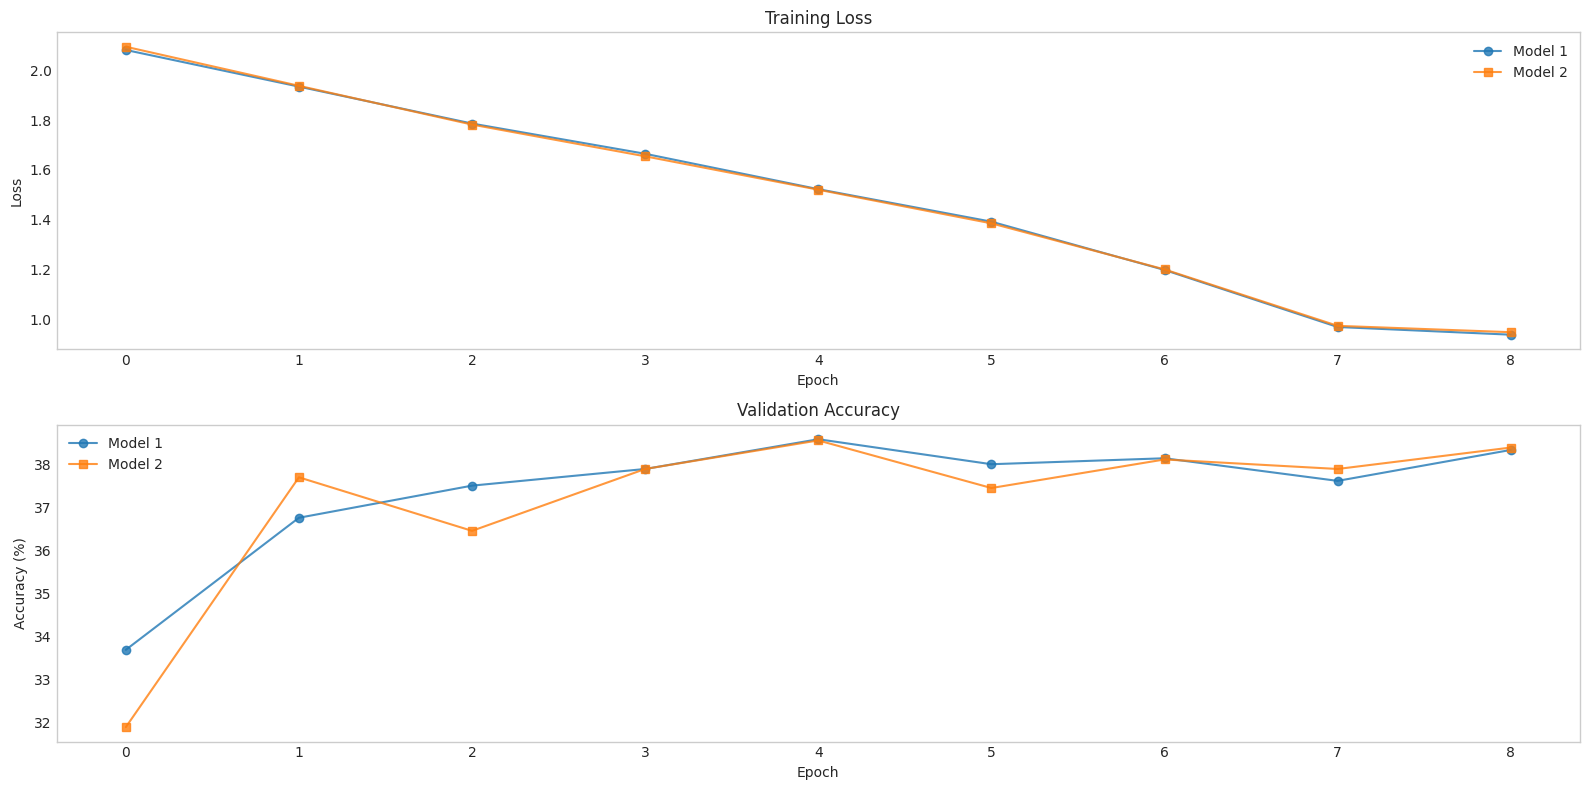

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.set_printoptions(precision=2, sci_mode=False)

num_runs = 1

# Symmetric Cross-Entropy Loss
sce_loss = SymmetricCrossEntropyLoss(alpha=1.0, beta=0.1, num_classes=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T_cifar_est = torch.load("T_cifar_est.pt").to(device)

for i in range(num_runs):

    np.random.seed(i)  # for replicability
    torch.manual_seed(i)

    # cifar 80:20 stratified split, Coteaching
    print("\n***CIFAR - Coteaching")
    train_loader, val_loader, test_loader = create_dataloaders_stratified(
        Xtr_cifar_t,
        Str_cifar_t,
        Xts_cifar_t,
        Yts_cifar_t,
        val_split=0.2,
        batch_size=64,
        seed=i,
    )

    # Initialize two models
    model1 = SmallResNet(num_classes=3).to(device)  # For CIFAR-class subset
    model2 = SmallResNet(num_classes=3).to(device)  # For CIFAR-class subset

    model1, model2, history = coteaching(
        model1,
        model2,
        train_loader,
        val_loader,
        loss_fn=sce_loss,
        forget_rate=0.4,
        num_gradual=10,
        disagreement_weight=0.05,
        num_epochs=20,
        warmup_epochs=10,
        eta=1e-4,
        eta_min=1e-6,
        patience=5,
    )

    ensemble_acc = compute_ensemble_top1_accuracy(model1, model2, test_loader)
    print(f"Ensemble Top-1 accuracy: {ensemble_acc:.2f}%")

    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    epochs = history['epoch']

    # Training Loss
    axes[0].plot(epochs, history['loss1'], label='Model 1', marker='o', alpha=0.8)
    axes[0].plot(epochs, history['loss2'], label='Model 2', marker='s', alpha=0.8)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Validation Accuracy
    axes[1].plot(epochs, history['val_acc1'], label='Model 1', marker='o', alpha=0.8)
    axes[1].plot(epochs, history['val_acc2'], label='Model 2', marker='s', alpha=0.8)
    axes[1].set_title('Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[0].grid(False)
    axes[1].grid(False)

    plt.tight_layout()
    plt.show()
